In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
import keras as K
from keras.models import Model, Sequential
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, SimpleRNN, Dense, Input
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import to_categorical
from keras.metrics import sparse_top_k_categorical_accuracy, sparse_categorical_accuracy
from keras.models import load_model

import nltk
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import helper as hlp
from data_gen import DataGenerator

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4776199820035018684]

In [3]:
data = hlp.load_reuters_dataset()

100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


In [4]:
for s in data.train[:10]:
    print(s)    

['But', 'some', 'exporters', 'said', 'that', 'while', 'the', 'conflict', 'would', 'hurt', 'them', 'in', 'the', 'long', '-', 'run', ',', 'in', 'the', 'short', '-', 'term', 'Tokyo', "'", 's', 'loss', 'might', 'be', 'their', 'gain', '.', '<EOS>']
['The', 'U', '.', 'S', '.', 'Has', 'said', 'it', 'will', 'impose', '300', 'mln', 'dlrs', 'of', 'tariffs', 'on', 'imports', 'of', 'Japanese', 'electronics', 'goods', 'on', 'April', '17', ',', 'in', 'retaliation', 'for', 'Japan', "'", 's', 'alleged', 'failure', 'to', 'stick', 'to', 'a', 'pact', 'not', 'to', 'sell', 'semiconductors', 'on', 'world', 'markets', 'at', 'below', 'cost', '.', '<EOS>']
['Unofficial', 'Japanese', 'estimates', 'put', 'the', 'impact', 'of', 'the', 'tariffs', 'at', '10', 'billion', 'dlrs', 'and', 'spokesmen', 'for', 'major', 'electronics', 'firms', 'said', 'they', 'would', 'virtually', 'halt', 'exports', 'of', 'products', 'hit', 'by', 'the', 'new', 'taxes', '.', '<EOS>']
['"', 'We', 'wouldn', "'", 't', 'be', 'able', 'to', 'do'

In [5]:
tokenizer = Tokenizer(
    lower=False,
    oov_token="<OOV>",
    filters=""
)
tokenizer.fit_on_texts(data.train)
vocab_size = len(tokenizer.word_index) + 1

vocab_size, len(data.train)

(36151, 38505)

In [6]:
train_corpus = tokenizer.texts_to_sequences(data.train)
dev_corpus = tokenizer.texts_to_sequences(data.dev)
test_corpus = tokenizer.texts_to_sequences(data.test)
len(train_corpus), len(dev_corpus), len(test_corpus) 

(38505, 8150, 8267)

/Users/Ed/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


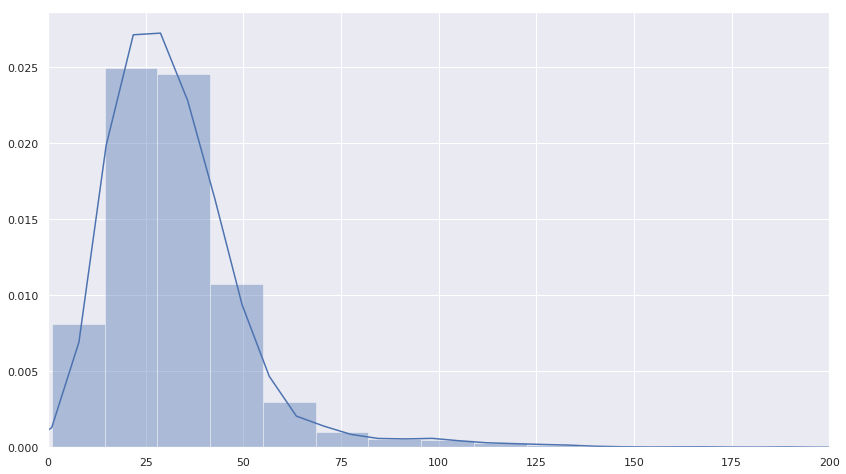

In [7]:
sequence_len = np.array([len(sent) for sent in train_corpus])
plt.figure(figsize=(14,8))
sns.distplot(sequence_len)
plt.xlim(0, 200)
plt.show()

In [8]:
print(sum(sequence_len > 75) / sequence_len.shape[0])

0.02747695104531879


In [9]:
max_sequence_len = 75

In [10]:
train_X, train_y = hlp.create_context_target_pairs(train_corpus)
dev_X, dev_y     = hlp.create_context_target_pairs(dev_corpus)
test_X, test_y   = hlp.create_context_target_pairs(test_corpus)

In [11]:
for i in range(5):
    print(train_X[i], train_y[i])

[166] 164
[166, 164] 1044
[166, 164, 1044] 9
[166, 164, 1044, 9] 33
[166, 164, 1044, 9, 33] 245


In [12]:
params = {
    "sparse" : True,
    "batch_size" : 512,
    "shuffle" : True,
    "maxlen" : 75
}

train_gen = DataGenerator(train_X, train_y, vocab_size, **params)
dev_gen = DataGenerator(dev_X, dev_y, vocab_size, **params)
test_gen = DataGenerator(test_X, test_y, vocab_size, **params)

In [13]:
# training

embedding_size = 100
n_units = 100

model = Sequential() 
model.add(Embedding(vocab_size, embedding_size, mask_zero=True, input_length=max_sequence_len-1))
model.add(SimpleRNN(n_units, return_sequences=True))
model.add(SimpleRNN(n_units))
model.add(Dense(vocab_size, activation="softmax"))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 74, 100)           3615100   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 74, 100)           20100     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 36151)             3651251   
Total params: 7,306,551
Trainable params: 7,306,551
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
epochs = 20
learning_rate = 0.01
decay_rate = learning_rate / epochs
rmsprop = K.optimizers.RMSprop(lr=learning_rate, decay=decay_rate)

In [15]:
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=rmsprop, 
    metrics=["sparse_top_k_categorical_accuracy"]
)

tensorboard = TensorBoard(log_dir="logs/")

training_history = model.fit_generator(
    generator=train_gen, 
    steps_per_epoch=1000,
    epochs=epochs,
    verbose=1,
    validation_data=dev_gen,
    callbacks=[tensorboard],
    use_multiprocessing=True,
    shuffle=True,
    initial_epoch=0
)



Epoch 1/20
  23/1000 [..............................] - ETA: 28:18 - loss: 7.8953 - sparse_top_k_categorical_accuracy: 0.1412

Process ForkPoolWorker-7:
Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/Ed/miniconda3/envs/nlp36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/Ed/miniconda3/envs/nlp36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/Ed/miniconda3/envs/nlp36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/Ed/miniconda3/envs/nlp36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/Ed/miniconda3/envs/nlp36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/Ed/miniconda3/envs/nlp36/lib/python3.6/multiprocessing/process.py", line 93, in ru

KeyboardInterrupt: 